# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [852]:
# Change here using YOUR first and last names
fn1 = "Xingyuan"
ln1 = "Xue"
fn2 = "Ling"
ln2 = "Jin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_xue_xingyuan_and_jin_ling.ipynb


Some imports

In [853]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

**ANSWER HERE**

In order to justify that the problem is convex, we will verify the following formulas are all convex:
$$\quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \quad (1)$$
$$\rho - \xi_i - \langle w, x_i \rangle  \quad 1 \leq i \leq n \quad (2)$$
$$- \xi_i \quad 1 \leq i \leq n \quad (3).$$

For (1), the Hessian matrix of $(w, \rho, \xi)$ H is a matrix whose first element is 1 and all the rest elements are 0. $\forall y, y^THy = y_1^Ty_1 \geq 0$, which means that H is a semi positive-definite matrix. So (1) is convex.

For (2) and (3), it is that same as the demonstration of (1). The Hessian matrix of (2) and (3) are semi positive-definite, so they are convex.

In summary, the problem $\mathcal{P}$ is convex.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

ANSWER HERE

**ANSWER**

- The Lagrangian of the problem $\mathcal{P}$ can be written as follows:

$$\mathcal{L}(w, \rho, \xi, \mu, \lambda)=\frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i-\sum_{i=1}^n\mu_i ( \langle w, x_i \rangle- \rho + \xi_i)-\sum_{i=1}^n\lambda_i \xi_i$$

With $\mu_i, \lambda_i\geq 0, 1\leq i\leq n$.

We take the derivatives with respect to $w, \rho, \xi$ and set those values to zeros. We have:
$$
 \left\{
 \begin{array}{lll}
 \frac{\partial L}{\partial w}=w-\sum_{i=1}^n\mu_ix_i=0 \Rightarrow w=\sum_{i=1}^n\mu_ix_i=G^{t}\mu
 \\
 \frac{\partial L}{\partial \rho}=\sum_{i=1}^n\mu_i-1=0 \Rightarrow \mu^{\top}1_n = 1
 \\
 \frac{\partial L}{\partial \xi_i}=\frac{1}{\nu n}-\mu_i-\lambda_i=0
 \end{array}
 \right .
$$
As $\mu_i,\lambda_i\geq 0$, the last equation can be written as $0\leq\mu_i\leq\frac{1}{\nu n}$. Putting these equations back into the Lagrangian $\mathcal{L}(w, \rho, \xi, \mu, \lambda)$, we can obtain the dual problem:
$$
\max_{\mu} -\frac{1}{2}\mu^{\top}GG^{t}\mu \Leftrightarrow \min_{\mu} \frac{1}{2}\mu^{\top}GG^{t}\mu
$$
With the box constraints and the constraint $\mu^{\top}1_n = 1$.

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>

**ANSWER HERE**

In question 2, we have worked out the saddle point of $w$ is $\sum_{i=1}^n\mu_ix_i$. As our prediction function is $\textrm{sign}(\langle w, x_i \rangle - \rho)$, it comes out that: $$y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .$$

## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

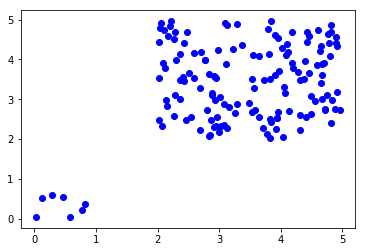

In [854]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_dataset(150)
plt.scatter(X[:, 0], X[:, 1], color='b');

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [855]:
import cvxopt


def qp(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
 
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [856]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

In [857]:
# TODO
def ocsvm_solver(K, nu=0.1):
    P = K
    q = np.zeros(P.shape[0])
    A = np.ones(P.shape[0]).reshape(1, P.shape[0])
    b = 1.0
    C = 1 / (nu*P.shape[0])
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver(K)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 15


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

In [858]:
mu_support

array([ 0.06711409,  0.06711409,  0.06040269,  0.06711409,  0.06711408,
        0.06711409,  0.06711409,  0.06711409,  0.06711409,  0.06711409,
        0.06711409,  0.06711409,  0.06711409,  0.06711409,  0.06711409])

In [859]:
# TODO
w = np.dot(mu_support, X[idx_support])

In [860]:
w

array([ 1.48709845,  1.42325338])

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

**ANSWER HERE**

For those $x_i$ with the corresponding $\mu_i>0$, as we have complementary slackness:
$$\mu_i ( \langle w, x_i \rangle- \rho + \xi_i)=0$$

We have $\rho= \langle w, x_i \rangle+ \xi_i$. 

If furthermore we have $\mu_i < \frac{1}{\nu n}$, as $\frac{1}{\nu n}-\mu_i-\lambda_i=0$, we have $\lambda_i>0$. From the complementary slackness for the second constraint $\lambda_i \xi_i=0$, we have $\xi_i=0$.

Thus for $0 < \mu_i < \frac{1}{\nu n}$, $\rho=w^{t}x_{i} $. 

For numeric stability, we use the mean of the estimations. The estimation of $\rho$ is thus given by:

$$\rho = \frac{1}{N_{\mathcal{M}}}\sum_{i=1}^{N_{\mathcal{M}}}\langle w, x_i \rangle$$
Where $\mathcal{M}$ is the collections of $x_i$ whose corresponding $\mu_i$ satisfying the condition $0 < \mu_i < \frac{1}{\nu n}$.

While in our case, it is more appropriate to choose the rows of K which corresponds to minimum $\mu$ support because of computation accuracy.

In [861]:
# TODO

def compute_rho(K, mu_support, idx_support):
    # TODO
    K_support = K[idx_support][:, idx_support]
    idx_min = np.argmin(mu_support)
    n_nu = 1 / (0.05*X.shape[0])
    # rho correspond to minimum rho
    rho = np.dot(K_support[idx_min], mu_support)
    # average rho for numerical stability
    #rho = sum(np.dot(mu_support, K_support[mu_support < n_nu]))/ K_support[mu_support < n_nu].shape[0]
    return rho

com_rho = compute_rho(K, mu_support, idx_support)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [862]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

# Check indices of support vectors
print(ocsvm.support_)
print(idx_support)

# Check rho
print(rho)
print(-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]
2.16400352023
2.16400355501
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

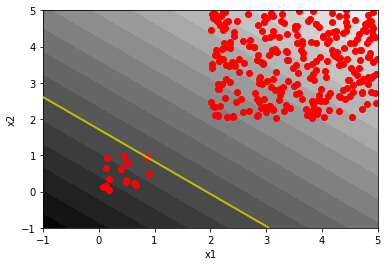

In [863]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function
    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

**ANSWER HERE** 
- coordinate descent: objective function of the primal problem is nonseperable and nonsmooth. However, the objective function of dual problem as following is seperable:
$$\min_{\mu} \frac{1}{2}\mu^TGG^t\mu - \sum_{i=1}^n\mu_i + \mathbb{I}_{[0, \frac{1}{n\nu}]^n }(\mu) $$
The first two terms is a differentiable convex function, the third term is a nonsmooth convex and separable function. So we can use Stochastic Dual Coordinate Descent to solve it.
- proximal gradient: The objective function above can be separated to a differentiable and a nonsmooth function, so we can use proximal gradient.
- stochastic gradient descent: As we can see, the objective function is not totally separable or smooth. 
- L-BFGS: In the dual problem, the objective function is twice-differentiable and we have a box constraint. L-BFGS-B can solve this kind of problems with box constraint.

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

**ANSWER HERE**

In case of using kernels, our samples and outliers become $\phi(x_i),\forall 1 \leq i \leq n$. As $<\phi(x_i), \phi(x_j)>=K(x_i,x_j)$, the Gram matrix in the problem can be written as $(<\phi(x_i), \phi(x_j)>)_{ij}=(K(x_i, x_j))_{ij}$. Thus the minimization dual problem can be reformulated by just using calls to $K$. 

The decision function is given by $f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho)$ originally while in this case, $x$ should be replaced by $\phi(x)$. Thus it is written as: 
$$f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i <\phi(x_i), \phi(x)> - \rho) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i K(x_i, x) - \rho)$$ 

Thus the decision function can also be reformulated by just using calls to $K$.

ANSWER HERE

We will use another dataset to evaluate this:

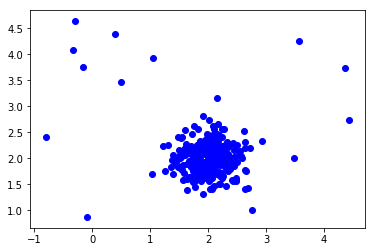

In [864]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [171]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X1[i] - X2[j])**2)  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

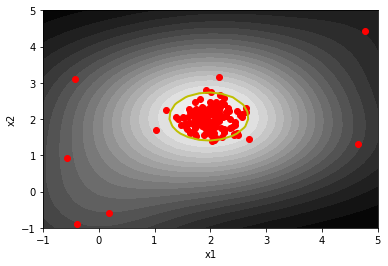

In [401]:
X = make_blob_dataset(150)

K = rbf_kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)

plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>

**ANSWER**

- The Lagrangian of the problem $\mathcal{P}$ can be written as follows:

$$\mathcal{L}(w, \xi, \mu, \lambda)=\frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i-\sum_{i=1}^n\mu_i ( \langle w, x_i \rangle- 1 + \xi_i)-\sum_{i=1}^n\lambda_i \xi_i$$

With $\mu_i, \lambda_i\geq 0, 1\leq i\leq n$.

We take the derivatives with respect to $w, \rho, \xi$ and set those values to zeros. We have:
$$
 \left\{
 \begin{array}{ll}
 \frac{\partial L}{\partial w}=w-\sum_{i=1}^n\mu_ix_i=0 \Rightarrow w=\sum_{i=1}^n\mu_ix_i=G^{t}\mu
 \\
 \frac{\partial L}{\partial \xi_i}=\frac{C}{n}-\mu_i-\lambda_i=0
 \end{array}
 \right .
$$
As $\mu_i,\lambda_i\geq 0$, the last equation can be written as $0\leq\mu_i\leq\frac{C}{n}$. Combining these equations together, we can obtain the dual problem $(\mathcal{D})$. We take all these parameters into Lagrangian of the problem and deduce that the dual problem is $(\mathcal{D})$:
$$\max_{\mu} -\frac{1}{2}\mu^{\top}GG^{t}\mu + \mu^{\top}1_n \Leftrightarrow \min_{\mu} \frac{1}{2}\mu^{\top}GG^{t}\mu - \mu^{\top}1_n
$$

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



**ANSWER HERE**

We can rewrite the dual as following formula:
$$\min_{\mu} \frac{1}{2}\mu^TGG^t\mu - \sum_{i=1}^n\mu_i + \mathbb{I}_{[0, \frac{C}{n}]^n }(\mu) $$
where $f(\mu) = \frac{1}{2}\mu^TGG^t\mu$ is a smooth funciton and $g(\mu)= - \sum_{i=1}^n\mu_i + \mathbb{I}_{[0, \frac{C}{n}]^n }(\mu) = - \sum_{i=1}^n (\mu_i + \mathbb{I}_{[0, \frac{C}{n}]}(\mu_i) )$ is a non-smooth and separable function.

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

### Data

In [824]:
n_samples = 150
X = make_blob_dataset(n_samples)
x0 = np.zeros(len(X))
K = rbf_kernel(X, X)
C = 15.
n_iter = 5000

### QP

In [819]:
def qp_2(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = None #cvxopt.matrix(A)
    b = None #cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
 
    return np.ravel(solution['x'])

In [820]:
# TODO
def qp_solver(K, X, C=C):
    P = K
    q = - np.ones(P.shape[0])
    A = None #np.zeros(P.shape[0]).reshape(1, P.shape[0])
    b = None #0.0
    C = C / P.shape[0]
    mu = qp_2(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    X_support = X[idx_support]
    G = rbf_kernel(X, X)
    min_svm = 1/2 * np.dot(mu, G.dot(mu)) - sum(mu)
    return mu_support, idx_support, min_svm

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support, min_svm = qp_solver(K, X)
print("Number of support vectors: %s" % idx_support.size)
print(min_svm)

Number of support vectors: 20
-1.18120352969


### Minimum and minimizer by L-BFGS-B

In [821]:
from scipy.optimize import fmin_l_bfgs_b
def min_f(x):
    return 0.5 * np.dot(K.dot(x), x) - np.sum(x)

def f_grad(x):
    return K.dot(x) - 1.

In [826]:
#bfgs_inspector = inspector(loss_svm, x0, min_f, verbose=True)
bounds = [(0, C / len(X)) for _ in range(len(X))]
x_min, f_min, _ = fmin_l_bfgs_b(func=min_f, x0=x0, fprime=f_grad, 
                      maxiter=5000, bounds=bounds, 
                      iprint=0)

### Proximal gradient with and without acceleration

- From the previous lesson, we know that $\sigma_{max}(GG^t)$ is the smoothness constant of $f(\mu)$. We denote it as $\mathcal{L}$.

- Thus the update rule of the proximal gradient method is: 
$$prox_{\frac{1}{\mathcal{L}}g}(v) \in Proj_{[0,\frac{C}{n}]^n}[v - \frac{1}{\mathcal{L}}\partial g(\mu_{v})] = Proj_{[0,\frac{C}{n}]^n}[v - \frac{1}{\mathcal{L}}(-\boldsymbol{1}_n)]$$
Where $v = \mu-\frac{1}{\mathcal{L}}\nabla f(\mu)$ and $\boldsymbol{1}_n = [1, \ldots, 1]^T$

- We use the rbf kernel to preprocess the data. Thus here $GG^t$ represents the Gram matrix using the rbf kernel.  

In [827]:
import time

def loss_svm(x):
    """Smooth term of svm"""
    return 0.5 * np.dot(K.dot(x), x)

def grad_svm(x, K):
    """Gradient of the smooth term"""
    return K.dot(x)

def prox_indicator(x, C, s):
    """Proximal operator for the indicator function at x"""  
    n = len(x)
    return np.minimum(np.maximum(x + s * 1., 0), C / n)
    
def indicator(x):
    """Value of the indicator function at x"""
    n = len(x)
    if np.min(x) < 0:
        return np.inf
    elif np.max(x) > C / n:
        return np.inf
    else:
        return -np.sum(x)
    
def loss_fun(x):
    return loss_svm(x) + indicator(x)

In [828]:
def inspector(loss_fun, x_real, f_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_real
        err = np.linalg.norm(xk - x_real)
        tim = time.time() - t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [829]:
### Proximal gradient without acceleration
def ista(K, x0, f, grad_f, g, prox_g, step, C, n_iter,
         x_true=None, verbose=True, callback=None):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    t0 = time.time()

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # timing history
    timing = []
    if x_true == None:
        x_true = np.ones(len(x0))
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = loss_fun(x)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in [
            "it", "obj", "err", "time"]]))
    for k in range(n_iter + 1):

        ##############
        x_new = prox_g(x - step * grad_f(x, K), C, s=step) # step = 1/L
        x = x_new.copy()
        ##############
        
        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x


# Proximal gradient with acceleration
def fista(K, x0, f, grad_f, g, prox_g, step, C, n_iter=50,
         x_true=None, verbose=True, callback=None):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    t0 = time.time()
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # timing history
    timing = []
    if x_true == None:
        x_true = np.ones(len(x0))
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = loss_fun(x)
    objectives.append(obj)
    t = 1.## beta
    t_new = 1.    
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in [
            "it", "obj", "err", "time"]]))
    for k in range(n_iter + 1):

        x_new = prox_g(z - step*grad_f(z, K), C, s=step)
        
        ## Beta iteration
        t_new = (1 + np.sqrt(1 + 4*t**2)) / 2
        
        ## z
        z = x_new + ((t - 1) / t_new)*(x_new - x)
        
        x = x_new.copy()
        t = t_new
            
        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

### ISTA & FISTA

In [830]:
step = 1. / np.linalg.norm(K, 2)

In [831]:
ista_inspector = inspector(loss_fun, x_min, f_min, verbose=False)
x_i  = ista(K, x0, loss_svm, grad_svm, indicator, prox_indicator, step, C, n_iter, callback=ista_inspector)

In [832]:
fista_inspector = inspector(loss_fun, x_min, f_min, verbose=False)
x_f  = fista(K, x0, loss_svm, grad_svm, indicator, prox_indicator, step, C, n_iter, callback=fista_inspector)

### Coordinate descent
Here we use a stochastic coordinate descent. And we update $K_{i:}\mu$ each time. But in bonus part, we propose another smart update.

In [833]:
# Some definitions before launching the algorithms
x0 = np.zeros(X.shape[0])

In [841]:
# generate indices of random samples
iis = np.random.randint(0, len(X), len(X) * n_iter)  

In [842]:
def prox_indicator_x(x, coef, s):
    """Proximal operator for the indicator function at x""" 
    # x is a float
    return np.minimum(np.maximum(x + s * 1., 0), coef)
    
def indicator_x(x):
    """Value of the indicator function at x"""
    if np.min(x) < 0:
        return np.inf
    elif np.max(x) > C / n_samples:
        return np.inf
    else:
        return -np.sum(x)

In [849]:
def cd_svm(x0, X, g, prox_g, n_iter=50, C=1,
              x_true=np.ones(X.shape[0]), verbose=True, callback=None):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 mu.T K mu + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    x_sum = x0.copy()
    
    n_samples, n_features = X.shape
    
    K = rbf_kernel(X, X)

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.dot(K.dot(x), x)  + g(x)
    objectives.append(obj)

    if verbose:
        print("Launching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter):
        i = iis[k]
        x_new[i] -= 1/K[i, i]*np.dot(K[i], x)
        x_new[i] = prox_g(x_new[i], C/n_samples, s=1/K[i, i])
        
        x = x_new.copy()
        x_sum += x
        
        # Update metrics after each iteration.
        if callback is not None and k % n_samples == 0: 
            callback(x)

    return x_sum / n_iter

In [850]:
cd_inspector = inspector(loss_fun, x_min, f_min, verbose=False)
x_cd = cd_svm(x0, X, indicator_x, prox_indicator_x, n_iter=len(X)*n_iter, C=C,
                 x_true=np.ones(X.shape[0]), verbose=False, callback=cd_inspector)

### L-BFGS-B

In [845]:
from scipy.optimize import fmin_l_bfgs_b
def min_f(x):
    return 0.5 * np.dot(K.dot(x), x) - np.sum(x)

def f_grad(x):
    return K.dot(x) - 1.

In [846]:
#bfgs_inspector = inspector(loss_svm, x0, min_f, verbose=True)
bounds = [(0, C / len(X)) for _ in range(len(X))]
bfgs_inspector = inspector(loss_fun, x_min, f_min, verbose=False)
_, _, _ = fmin_l_bfgs_b(func=min_f, x0=x0, fprime=f_grad, 
                        maxiter=n_iter, bounds=bounds, 
                        callback=bfgs_inspector)

### Performance plot

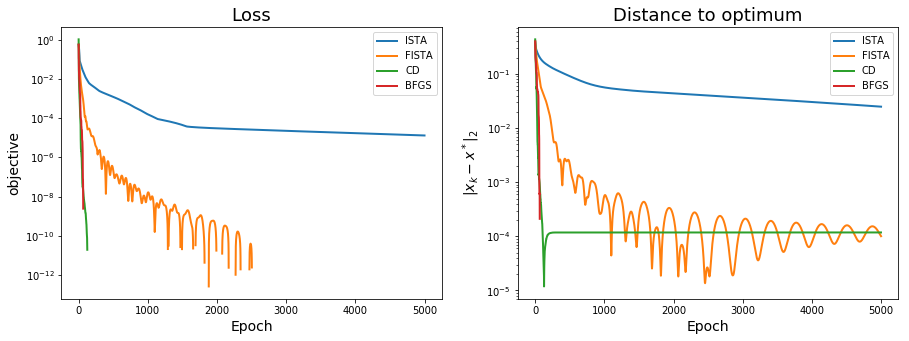

In [851]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cd_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CD", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

### Performance comparation
- First of all, we choose the accurate minimum and minimizer by L-BFGS-B of high-iteration. Then we compare results of all four algorithms. 
- Iteration number is 5000 and sample size is 150.
- After trying several C values, we choose 15 as an appropriate C.
- From the loss and distance to optimum, the order of performance is $ISTA<FISTA<L-BFGS-B<CG$. Coordinate descent is the best one. It converges faster than others and has the minimum loss and distance to optimum. For each epoch, coordinate descent iterate the number of samples n times, which means that it adjusts directions n times more than other algorithms. However, after the convergence, the distance to optimum of coordinate descente bonce and remains stable. Then FISTA flatuates around the distance to optimum of coordinate descent.  
- L-BFGS-B also has a good performance because it is a seconde order method. In this case, L-BFGS-B performs worse than coordinate descent. Compared to the last lab where L-BFGS-B performs better than coordinate descent, maybe it depends on dataset.
- FISTA converges with bounds which we have already seen in previous labs. However, when we choose a different C like 10, we cannot observe clear bounds. Besides, FISTA converges and performs better than ISTA. 

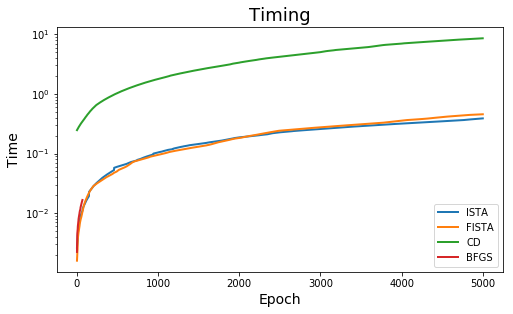

In [848]:
plt.figure(figsize=(8, 4.5))

plt.subplot(1, 1, 1)

inspectors = [ista_inspector, fista_inspector, cd_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CD", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.timing, lw=2)
    plt.title("Timing", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Time", fontsize=14)

plt.legend(solvers)

### Computation time

- In terms of computation time, we have: $CD > BFGS> FISTA \approx ISTA$.The last three methods are close in terms of computation time. BFGS is slower than ISTA and FISTA as it involves doing Cholesky factorization and line search and that it is more time-consuming for each iteration. CD is much more time-consuming than other methods as we compare the time of number of samples n iterations in the coordinate descent method with one iteration in other methods. In coordinate descent method, we do n times more iterations in a loop, which may implicate n times more type checking and other costs for implementing iterations in loops in Python. Thus it is slow. Normally, FISTA should be slower than ISTA. Here the observation does not match this expectation, which may be due to the fact that the difference is not so obvious.

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

**You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**

**BONUS**

- In our implementation, we update $\mu_i$ with $Prox_{\frac{1}{K_{ii}}g}(\mu_i-\nabla f_i(\mu))=Prox_{\frac{1}{K_{ii}}g}(\mu_i-K_i^\top \mu)$ where $K_i$ is the $i^{th}$ row of $K$. In this case, the computation cost is of $O(n)$ with $n$ the number of samples.

- Another possible way of doing smart update is to store $K\mu$ in memory and each time we use its $i^{th}$ element to update $\mu_i$ and we update the $K\mu$ by $K\mu+K_{:i}\mu_{i}^{new}-K_{:i}\mu_{i}^{old}$, which also has a computation cost of $O(n)$.